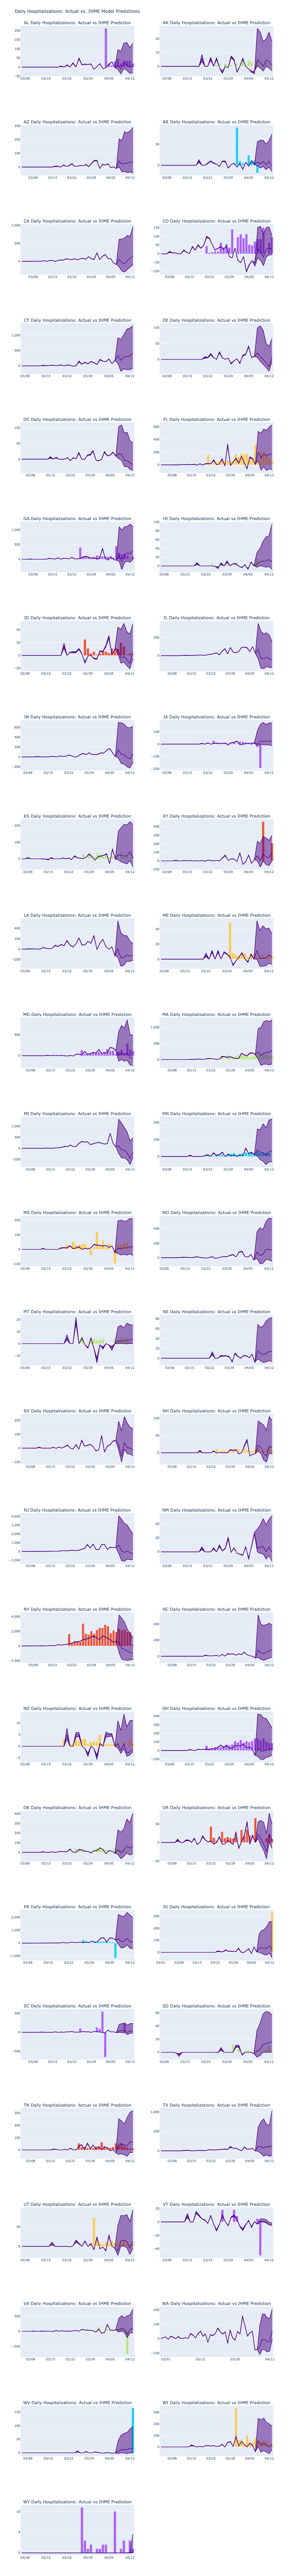

In [1]:
# https://covidtracking.com
# https://covid19.healthdata.org/projections

import requests
import pandas as pd
import numpy as np
import math
import json
from IPython.display import Markdown as md
from datetime import timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf

import os

# Load Latest COVID Actual Data from covidtracking.com

state_df_list = []
with open('states_history.json') as data:
    all_state_hist = pd.read_json(data)

drop_columns = ["total",
                "dateChecked",
                "hash",
               ]

# Load IMHE Projections
with open('./ihme/Hospitalization_all_locs.csv') as data:
    imhe_model = pd.read_csv(data)

# Load State Population file
with open('state_populations.json') as data:
    state_pop = pd.read_json(data)

with open('state_hospital_beds.json') as data:
    state_beds = pd.read_json(data)
    

# Drop states
drop_states = ["PR",
               "AS",
               "GU",
               "MP",
               "VI",
              ]

for state in drop_states:
    state_pop.drop(state_pop[state_pop.state_code == state].index, inplace=True)
    state_beds.drop(state_beds[state_beds.state_code == state].index, inplace=True)

state_codes = state_pop['state_code'].to_list()
state_names = state_pop['state_name'].to_list()
states = []
for i in range(len(state_codes)):
    states.append((state_codes[i], state_names[i]))

state_final_tuple_list = [] # state_code, state_name, state_population, state_covid_df, state_bed_df
for state_code, state_name in states:
    # Load Hospital Bed Info
    state_bed_model = imhe_model[imhe_model.location_name == state_name]
    state_bed_model = state_bed_model[['location_name', 'date', 'allbed_mean', 'allbed_lower', 'allbed_upper']]
    state_bed_model['date'] = pd.to_datetime(state_bed_model['date'], format="%Y-%m-%d")
    #state_beds_df_list.append((state_code, state_name, state_bed_model))
    
    state_population = state_pop[state_pop.state_code == state_code].population.sum()
    df = all_state_hist[all_state_hist.state == state_code]
    # Drop unnecessary columns
    df.drop(columns=drop_columns, inplace=True)
    df.fillna(0, inplace=True)
    # Create new columns in covid dataframe
    df['infectionRate'] = df['positive'].div(state_population, fill_value=0)
    df['totalPositiveRate'] = df['positive'].div(df['totalTestResults'], fill_value=0)
    df['totalHospitalRate'] = df['hospitalized'].div(df['positive'], fill_value=0)
    df['totalDeathRate'] = df['death'].div(df['positive'], fill_value=0)
    df['newPositiveRate'] = df['positiveIncrease'].div(df['totalTestResultsIncrease'], fill_value=0)
    df['date'] = pd.to_datetime(df['date'], format="%Y%m%d")
    #state_covid_df_list.append((state, df, state_population))
    
    state_beds = pd.merge(left=df, right=state_bed_model, how='left', left_on='date', right_on='date')
    state_beds = state_beds[['date', 'state', 'hospitalizedCumulative', 'allbed_mean', 'allbed_lower', 'allbed_upper']]
    state_beds = state_beds.set_index('date')
    for column, new_column in [('hospitalizedCumulative', 'hospInc'), 
                           ('allbed_mean', 'abmInc'),
                           ('allbed_lower', 'ablInc'),
                           ('allbed_upper', 'abuInc'),
                          ]:
        state_cum = state_beds[column].to_list()
        state_inc = []
        for i in range(len(state_cum)):
            if i < len(state_cum)-1:
                state_inc.append(state_cum[i]-state_cum[i+1])
            elif i == len(state_cum)-1:
                state_inc.append(0.0)
        state_beds[new_column] = np.array(state_inc)

    state_beds['abm_delta'] = state_beds['hospitalizedCumulative'].sub(state_beds['allbed_mean'])
    state_beds['abl_delta'] = state_beds['hospitalizedCumulative'].sub(state_beds['allbed_lower'])
    state_beds['abu_delta'] = state_beds['hospitalizedCumulative'].sub(state_beds['allbed_upper'])
    state_beds['abm_inc_delta'] = state_beds['hospInc'].sub(state_beds['abmInc'])
    state_beds['abl_inc_delta'] = state_beds['hospInc'].sub(state_beds['ablInc'])
    state_beds['abu_inc_delta'] = state_beds['hospInc'].sub(state_beds['abuInc'])
    state_beds['cumulativeMeanError'] = state_beds['abm_delta'].div(state_beds['hospitalizedCumulative'], fill_value=0)
    state_beds['cumulativeLowerError'] = state_beds['abl_delta'].div(state_beds['hospitalizedCumulative'], fill_value=0)
    state_beds['cumulativeUpperError'] = state_beds['abu_delta'].div(state_beds['hospitalizedCumulative'], fill_value=0)
    state_beds['dailyMeanError'] = state_beds['abm_inc_delta'].div(state_beds['hospInc'], fill_value=0)
    state_beds['dailyLowerError'] = state_beds['abl_inc_delta'].div(state_beds['hospInc'], fill_value=0)
    state_beds['dailyUpperError'] = state_beds['abu_inc_delta'].div(state_beds['hospInc'], fill_value=0)

    state_beds_delta = state_beds[['abm_delta', 'abl_delta', 'abu_delta']]
    state_beds_cumulative_error = state_beds[['cumulativeMeanError', 'cumulativeLowerError', 'cumulativeUpperError']]
    state_beds_daily_error = state_beds[['dailyMeanError', 'dailyLowerError', 'dailyUpperError']]
    
    state_final_tuple_list.append((state_code, state_name, state_population, df, state_beds))

titles = []
for state_code, state_name in states:
    titles.append("{} Daily Hospitalizations: Actual vs IHME Prediction".format(state_code))

fig = make_subplots(rows=26, cols=2, subplot_titles=titles)
row_num = 1
col_num = 1

for state_code, state_name, state_population, state_covid_df, state_bed_df in state_final_tuple_list:
    #print("row: {}, col: {}".format(row_num, col_num))

    fig.add_trace(go.Scatter(x=state_bed_df.index, y=state_bed_df.ablInc,
            fill=None,
            mode='lines',
            line_color='indigo',
            name='IHME Lower',
            showlegend=False,
        ),
        row=row_num,
        col=col_num
        )
    fig.add_trace(go.Scatter(x=state_bed_df.index, y=state_bed_df.abuInc,
            fill='tonexty', # fill area between trace0 and trace1
            mode='lines',
            line_color='indigo',
            name='IHME Upper',
            showlegend=False,
        ),
        row=row_num,
        col=col_num
        )
    fig.add_trace(go.Scatter(x=state_bed_df.index, y=state_bed_df.abmInc,
            line_color='indigo',
            name='IHME Mean Prediction',
            showlegend=False,
        ),
        row=row_num,
        col=col_num
        )
    fig.add_trace(go.Bar(x=state_bed_df.index, y=state_bed_df.hospInc,
            name='Actual Increase',
            showlegend=False,
        ),
        row=row_num,
        col=col_num
        )
    fig.update_xaxes(tickformat='%m/%d', row=row_num, col=col_num)
    fig.update_yaxes(tickformat='0,0', row=row_num, col=col_num)
    if col_num == 1:
        col_num += 1
    elif col_num == 2:
        row_num += 1
        col_num = 1
    
    #fig.update_layout(title_text="{} Daily Hospitalizations: Actual vs. IMHE Model Predictions".format(state_code), height=400, width=600)
fig.update_layout(title_text="Daily Hospitalizations: Actual vs. IHME Model Predictions", height=10000, width=1200)
fig.show()

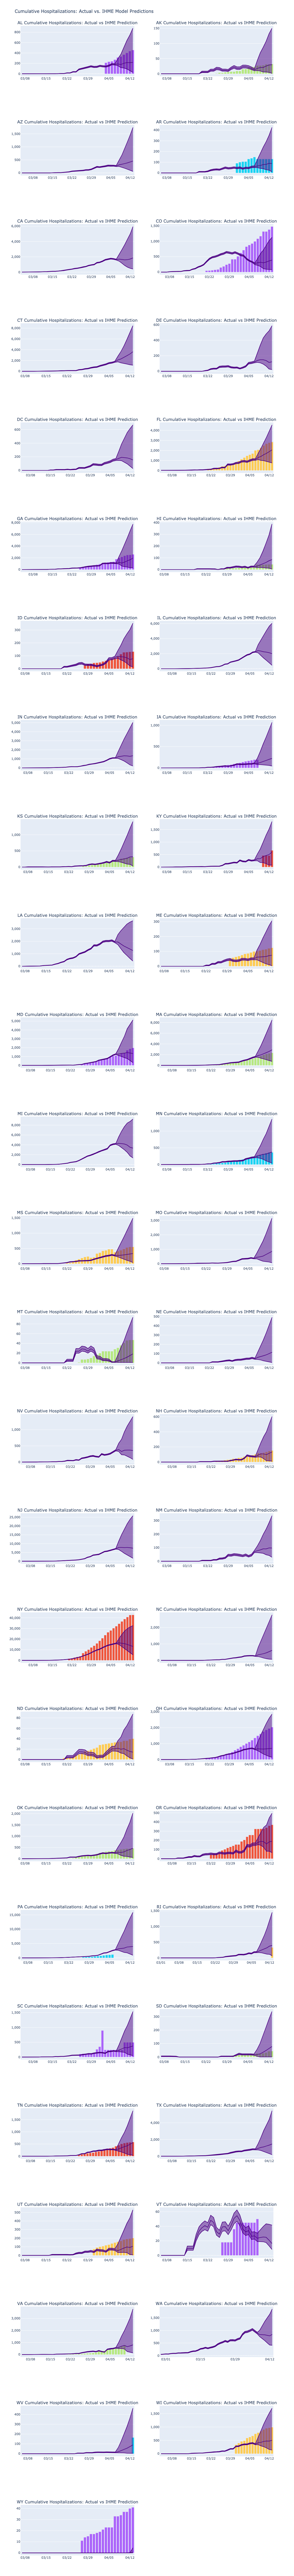

In [2]:
titles = []
for state_code, state_name in states:
    titles.append("{} Cumulative Hospitalizations: Actual vs IHME Prediction".format(state_code))

fig = make_subplots(rows=26, cols=2, subplot_titles=titles)
row_num = 1
col_num = 1

for state_code, state_name, state_population, state_covid_df, state_bed_df in state_final_tuple_list:
    #print("row: {}, col: {}".format(row_num, col_num))

    fig.add_trace(go.Scatter(x=state_bed_df.index, y=state_bed_df.allbed_lower,
            fill=None,
            mode='lines',
            line_color='indigo',
            name='IHME Lower',
            showlegend=False,
        ),
        row=row_num,
        col=col_num
        )
    fig.add_trace(go.Scatter(x=state_bed_df.index, y=state_bed_df.allbed_upper,
            fill='tonexty', # fill area between trace0 and trace1
            mode='lines',
            line_color='indigo',
            name='IHME Upper',
            showlegend=False,
        ),
        row=row_num,
        col=col_num
        )
    fig.add_trace(go.Scatter(x=state_bed_df.index, y=state_bed_df.allbed_mean,
            line_color='indigo',
            name='IHME Mean Prediction',
            showlegend=False,
        ),
        row=row_num,
        col=col_num
        )
    fig.add_trace(go.Bar(x=state_bed_df.index, y=state_bed_df.hospitalizedCumulative,
            name='Actual Cumulative Hospitalizations',
            showlegend=False,
        ),
        row=row_num,
        col=col_num
        )
    fig.update_xaxes(tickformat='%m/%d', row=row_num, col=col_num)
    fig.update_yaxes(tickformat='0,0', row=row_num, col=col_num)
    if col_num == 1:
        col_num += 1
    elif col_num == 2:
        row_num += 1
        col_num = 1
    
    #fig.update_layout(title_text="{} Daily Hospitalizations: Actual vs. IMHE Model Predictions".format(state_code), height=400, width=600)
fig.update_layout(title_text="Cumulative Hospitalizations: Actual vs. IHME Model Predictions", height=10000, width=1200)
fig.show()